In [1]:
pip install pyDOE


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18206 sha256=bc7135235e6190d1bbfc35b7300adf04adf48cf33dfaf26d5fefe6d5bc6660a9
  Stored in directory: c:\users\maryam\appdata\local\pip\cache\wheels\83\ce\8a\87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from numpy.linalg import eig
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
from scipy import*

In [4]:
def kernel(x1, x2, omega):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2*np.dot(x1, x2.T)
    return np.exp(-10** omega[0]* sqdist )

In [5]:
def gp_regression(X, y, X_star, omega):
    n=len(X)
    K = kernel(X, X, omega)+(10**omega[1])*np.eye(X.shape[0])
    a=10**omega[1]
    print(np.linalg.det(K))
    if np.linalg.det(K)==0 or np.linalg.det(K)<=0 :
      print('determinant is negative')
      eigenvalues, eigenvectors = np.linalg.eig(K)
      min_eigenvalue = np.min(eigenvalues)
      a=10**-8-np.real(min_eigenvalue)
      K = kernel(X, X, omega)+a*np.eye(X.shape[0])
    K_inv=np.linalg.inv(K)
    var=(np.dot(y.T, np.dot(K_inv, y)))/n
    print('var is',var)
    if var<=0:
      print('variance is negative')
      eigenvalues, eigenvectors = np.linalg.eig(K)
      min_eigenvalue = np.min(eigenvalues)
      a=10**-8-np.real(min_eigenvalue)
      K = kernel(X, X, omega)+a*np.eye(X.shape[0])
      K_inv=np.linalg.inv(K)
      var=(np.dot(y.T, np.dot(K_inv, y)))/n
    K_star = kernel(X, X_star, omega)
    f_star=K_star.T.dot(K_inv).dot(y)
    var_f_star=(kernel(X_star, X_star, omega)- K_star.T.dot(K_inv).dot(K_star))*var
    return f_star, var_f_star
    #omega[1] should be in log space

In [6]:
def Log_Liklihood(omega,X,y):
    n = len(X)
    K = kernel(X, X, omega)+(10**omega[1])*np.eye(X.shape[0])
    a=10**omega[1]
    if np.linalg.det(K)==0 or np.linalg.det(K)<=0 :
      # print(np.linalg.det(K))
      eigenvalues, eigenvectors = np.linalg.eig(K)
      min_eigenvalue = np.min(eigenvalues)
      a=10**-8-np.real(min_eigenvalue)
      K = kernel(X, X, omega)+a*np.eye(X.shape[0])
      # print('new det is',np.linalg.det(K))
    K_inv = np.linalg.inv(K )
    var=(np.dot(y.T, np.dot(K_inv, y)))/n
    if var<=0:
      # print('var is negative in log')
      eigenvalues, eigenvectors = np.linalg.eig(K)
      min_eigenvalue = np.min(eigenvalues)
      # print(min_eigenvalue)
      a=10**-8-np.real(min_eigenvalue)
      K = kernel(X, X, omega)+a*np.eye(X.shape[0])
      K_inv = np.linalg.inv(K )
      var=(np.dot(y.T, np.dot(K_inv, y)))/n
    log_likelihood =-(n/2)*np.log(var)- 0.5*np.log(np.linalg.det(K))
    return -log_likelihood
    ##Input of omega[1] in logspace

In [7]:
def prior(roughness,nugget,rough_mean,nug_mean):
    prior_ruf=(1.0/np.sqrt(2*np.pi))*np.exp(-(roughness-rough_mean)**2/2)
    prior_nug=(1.0/((10**nugget)*np.sqrt(2*np.pi)))*np.exp(-(np.log(10**(nugget))-nug_mean)**2) #lognormal
    return prior_ruf*prior_nug



In [8]:
def unnormalized_posterior(omega,mean_ruf,mean_nug,Log_Liklihood, prior,X,y):
    liklihood=-Log_Liklihood(omega,X,y)

    prior_distribution=prior(omega[0],10**omega[1],mean_ruf,mean_nug)

    posterior=(np.exp(liklihood)*prior_distribution)
    if np.isinf(posterior):
      print(' poster is inf')
      posterior=-1
    elif np.isneginf(posterior):
      posterior=-1
      print('poster is negif')
    elif np.isnan(posterior):
      posterior=-1
      print('poster is Nan')
    return(-posterior)
    #omega[1] in log space,mean_nug in real space

In [9]:
##define Branin and Currin function (#Check booked marked page for more details about this)
def branin(x1):
    term1 = (x1[:,1] - (5.1 / (4 * np.pi**2)) * x1[:,0]**2 + (5 / np.pi) * x1[:,0] - 6)**2
    term2 = 10 * (1 - 1 / (8 * np.pi)) * np.cos(x1[:,0])
    return term1 + term2 + 10
# def currin(x1):
#     return 1 / ((1 + x1[:,1] * (1 - np.exp(-1 / (2 * x1[:,1]))))**2)
def currin(x1):
  Cur=4.9+21.15*x1[:,0]-2.17*x1[:,1]-15.88*x1[:,0]**2-1.38*x1[:,1]**2-5.26*x1[:,1]*x1[:,0]
  return Cur

In [10]:
###Define Sphere function
def Sphere(x1):
  sph=(x1[:,0]-2)**2+(x1[:,1]-2)**2
  return sph

def bohachovskey(x1):
  boha=x1[:,0]**2+2*x1[:,1]**2-0.3*np.cos(3*np.pi*x1[:,0])-0.4*np.cos(4*np.pi*x1[:,0])+0.7
  return boha

In [11]:
##Functions related to MOBO
#Function to define dominancy
# def identify_pareto(costs):  ##pareto front for minimization
#     is_pareto = np.ones(costs.shape[0], dtype=bool)
#     for i, cost in enumerate(costs):
#         if is_pareto[i]:
#             is_pareto[is_pareto] = np.any(costs[is_pareto] <= cost, axis=1)
#     return is_pareto

### Identify pareto front for maximization
def identify_pareto_max(costs):  ##pareto front for minimization
    is_pareto = np.ones(costs.shape[0], dtype=bool)
    for i, cost in enumerate(costs):
        if is_pareto[i]:
            is_pareto[is_pareto] = np.any(costs[is_pareto] >= cost, axis=1)
    return is_pareto


##Function to define Hyper volume
# def HyperVolume(sorted_PF,Ref_point):
#     area=0
#     for i in range (len(sorted_PF)):
#         if i!=len(sorted_PF)-1:
#             if sorted_PF[i][0]==sorted_PF[i-1][0]:
#                 if i!=0:
#                     area+=(sorted_PF[i+1][0]-sorted_PF[i][0])*(Ref_point[1]-min(sorted_PF[i][1],sorted_PF[i-1][1]))
#                 elif i==0:
#                     area+=(sorted_PF[1][0]-sorted_PF[0][0])*(Ref_point[1]-min(sorted_PF[1][1],sorted_PF[0][1]))
#             else:
#                 area+=(sorted_PF[i+1][0]-sorted_PF[i][0])*(Ref_point[1]-sorted_PF[i][1])
#         elif i==len(sorted_PF)-1:
#             if sorted_PF[i][0]==sorted_PF[i-1][0]:
#                 area+=(Ref_point[0]-sorted_PF[i][0])*(Ref_point[1]-min(sorted_PF[i][1],sorted_PF[i-1][1]))
#             else:
#                 area+=(Ref_point[0]-sorted_PF[i][0])*(Ref_point[1]-sorted_PF[i][1])
#     return(area)

In [12]:
##Function for normalizing
def normalizing(array):
  min_val=np.min(array)
  max_val=np.max(array)
  return(array-min_val)/(max_val-min_val)

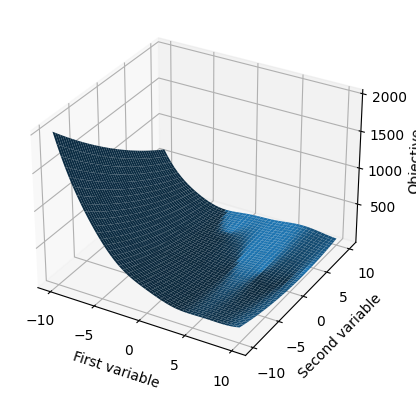

In [20]:
##Plot Functions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X1, X2 = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))
X_train= np.c_[X1.ravel(), X2.ravel()]
y_train1=branin(X_train)
y_train1=y_train1.reshape(X1.shape)
ax.plot_surface(X1, X2, y_train1)

ax.set_xlabel('First variable')
ax.set_ylabel('Second variable')
ax.set_zlabel('Objective')
plt.savefig('Branin')
plt.show()

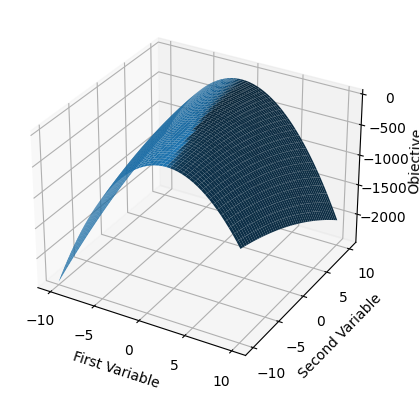

In [19]:
##Plot Currin#
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X1, X2 = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))
X_train= np.c_[X1.ravel(), X2.ravel()]
y_train1=currin(X_train)
y_train1=y_train1.reshape(X1.shape)
ax.plot_surface(X1, X2, y_train1)

ax.set_xlabel('First Variable')
ax.set_ylabel('Second Variable')
ax.set_zlabel('Objective')
plt.savefig('Currin')
plt.show()

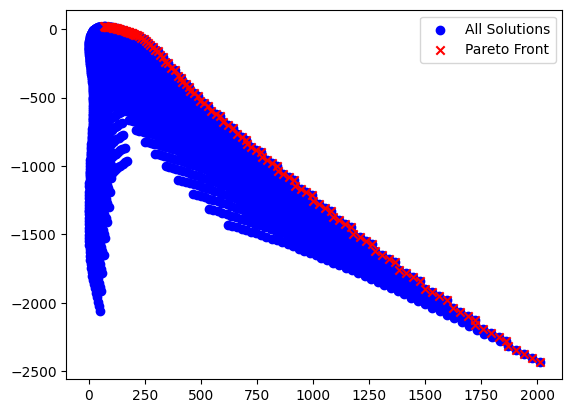

In [15]:
###Plot real function  #### I plot in the domain that face book paper assigned
###Ploting True pareto front
X1, X2 = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))####This is the domain
X_train= np.c_[X1.ravel(), X2.ravel()]
  #F1 function values (Branin) #training value
y_train1=branin(X_train)
y_train1=y_train1

  #F2 function values (Currin) training vale
y_train2=currin(X_train)
y_train2=y_train2
Initial_candidate=np.column_stack((y_train1, y_train2))
is_pareto=identify_pareto_max(Initial_candidate)
Initial_pareto=Initial_candidate[is_pareto]
plt.scatter(y_train1, y_train2, label='All Solutions', c='b', marker='o')
plt.scatter(Initial_pareto[:, 0], Initial_pareto[:, 1], label='Pareto Front', c='r', marker='x')
plt.legend()
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.savefig('real PF')
plt.show()


In [21]:
##Function to define Hyper volume for maximization  and plot
def HyperVolume_maximization(sorted_PF,Ref_point):
    area=0
    # plt.scatter(Ref_point[0],Ref_point[1],marker='x')
    for i in range (len(sorted_PF)):
        if i!=len(sorted_PF)-1:
            if sorted_PF[i][0]==sorted_PF[i+1][0]:
                if i!=0:
                    merged_array = np.vstack(sorted_PF)
                    unique_first_components = merged_array[:, 0]==sorted_PF[i][0]
                    same_x=merged_array[unique_first_components]
                    max_y=max(same_x[:,1])
                    area+=(sorted_PF[i][0]-sorted_PF[i-1][0])*(max_y-Ref_point[1])
                    # x_min=sorted_PF[i-1][0]
                    # x_max=sorted_PF[i][0]
                    # x=np.linspace(x_min,x_max)
                    # plt.fill_between(x,max_y,Ref_point[1], where=(x >= x_min) & (x <= x_max), interpolate=True, color='b', alpha=0.8)
                    # plt.scatter(sorted_PF[i][0],sorted_PF[i][1],marker='o')
                    i=i+len(same_x)
                elif i==0:
                    merged_array = np.vstack(sorted_PF)
                    unique_first_components = merged_array[:, 0]==sorted_PF[i][0]
                    same_x=merged_array[unique_first_components]
                    max_y=max(same_x[:,1])
                    area+=(sorted_PF[i][0]-Ref_point[0])*(max_y-Ref_point[1])
                    # x_min=Ref_point[0]
                    # x_max=sorted_PF[i][0]
                    # x=np.linspace(x_min,x_max)
                    # plt.fill_between(x,max_y,Ref_point[1], where=(x >= x_min) & (x <= x_max), interpolate=True, color='b', alpha=0.8)
                    # plt.scatter(sorted_PF[i][0],sorted_PF[i][1],marker='o')
                    i=i+len(same_x)
            else:
              if i!=0:
                  area+=(sorted_PF[i][0]-sorted_PF[i-1][0])*(max(sorted_PF[i][1],sorted_PF[i-1][1])-Ref_point[1])
                  # x_min=sorted_PF[i-1][0]
                  # x_max=sorted_PF[i][0]
                  # x=np.linspace(x_min,x_max)
                  # plt.fill_between(x,sorted_PF[i][1],Ref_point[1], where=(x >= x_min) & (x <= x_max), interpolate=True, color='b', alpha=0.8)
                  # plt.scatter(sorted_PF[i][0],sorted_PF[i][1],marker='o')
              elif i==0:
                  area+=(sorted_PF[i][0]-Ref_point[0])*(sorted_PF[i][1]-Ref_point[1])
                  x_min=Ref_point[0]
                  x_max=sorted_PF[i][0]
                  x=np.linspace(x_min,x_max)
                  # plt.fill_between(x,sorted_PF[i][1],Ref_point[1], where=(x >= x_min) & (x <= x_max), interpolate=True, color='b', alpha=0.8)
                  # plt.scatter(sorted_PF[i][0],sorted_PF[i][1],marker='o')

        elif i==len(sorted_PF)-1:
            if sorted_PF[i][0]==sorted_PF[i-1][0]:
              continue
            else:
                area+=(sorted_PF[i][0]-sorted_PF[i-1][0])*(sorted_PF[i][1]-Ref_point[1])
                x_min=sorted_PF[i-1][0]
                x_max=sorted_PF[i][0]
                # x=np.linspace(x_min,x_max)
                # plt.fill_between(x,sorted_PF[i][1],Ref_point[1], where=(x >= x_min) & (x <= x_max), interpolate=True, color='b', alpha=0.8)
                # plt.scatter(sorted_PF[i][0],sorted_PF[i][1],marker='o')
    plt.show()
    return(area)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


Branin function is [-2.16986421 -4.63013263]
Currin function is [-2.66600308 -6.8363661 ]
8.697683447596169e-13
var is 277152.32674578007
3.024153128068585e-21
var is 5047762.823118171


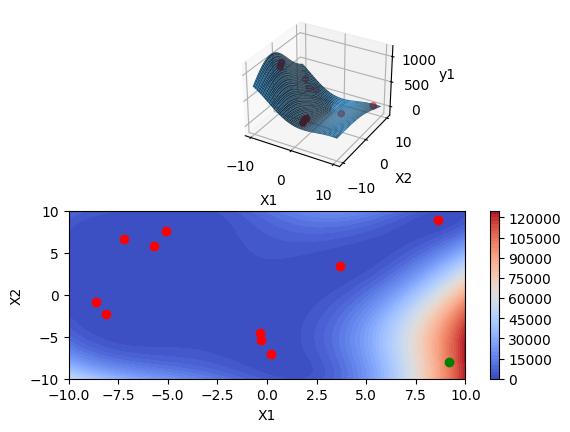

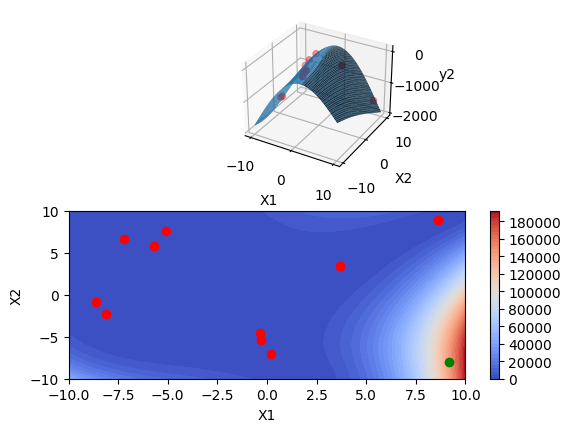

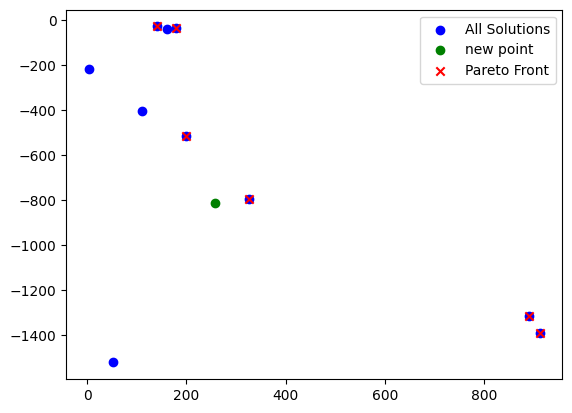

Branin function is [-2.54266368 -5.31118831]
Currin function is [-3.01455884 -7.06721353]
9.932406221567329e-20
var is [[1194945.19091552]]
6.414979596144073e-30
var is [[16965263.6725893]]


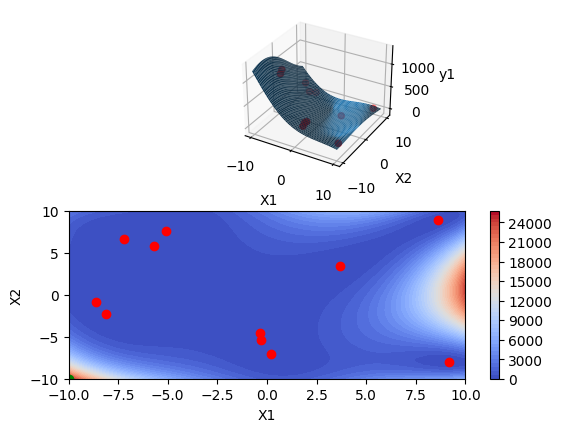

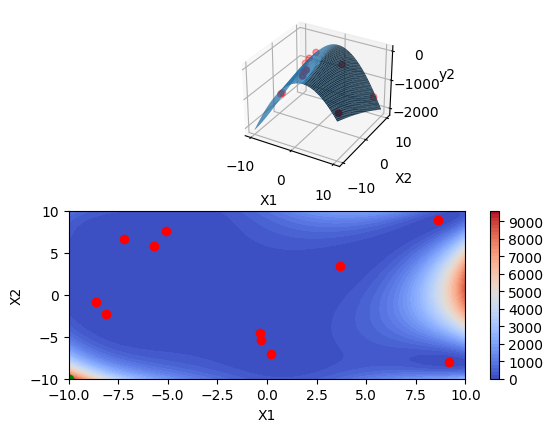

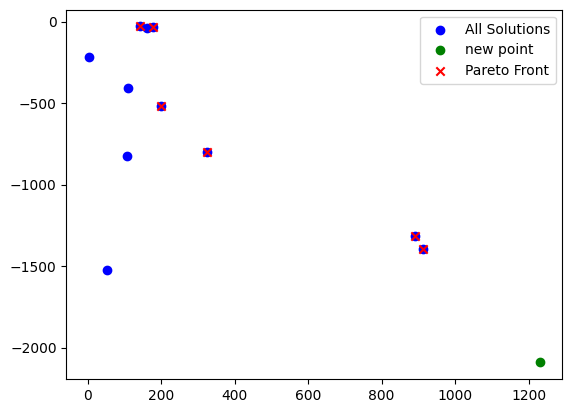

Branin function is [-3.25242106 -5.61912242]
Currin function is [-3.25242106 -5.61912242]
9.603195918740157e-36
var is [[52690125.92443272]]
9.603195918740157e-36
var is [[49656684.16998062]]


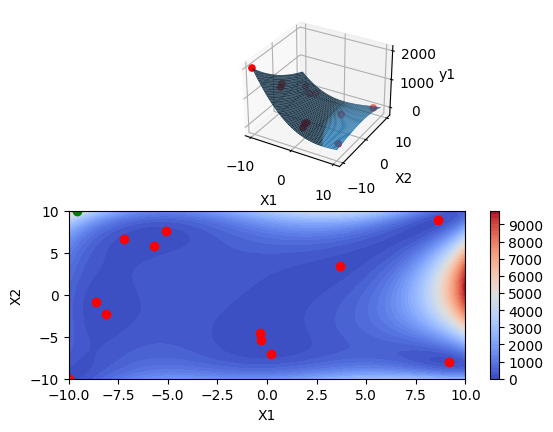

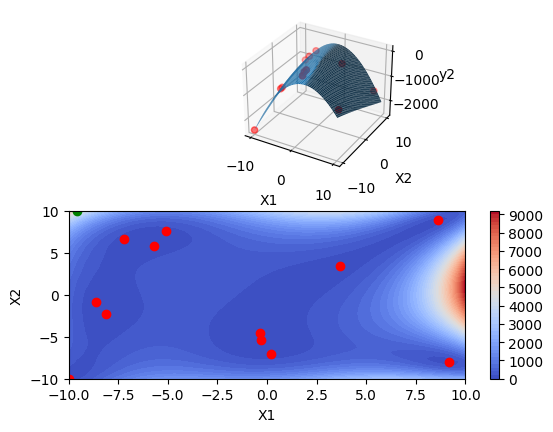

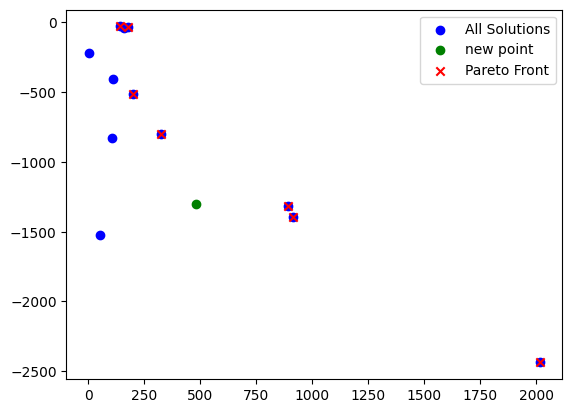

Branin function is [-2.87885886 -5.07827295]
Currin function is [-3.61186564 -6.67358536]
4.533526828069896e-31
var is [[9964669.28554605]]
6.775541860795553e-50
var is [[2.02646959e+08]]


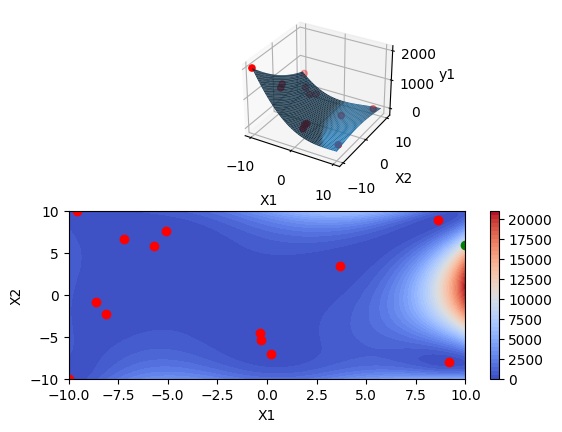

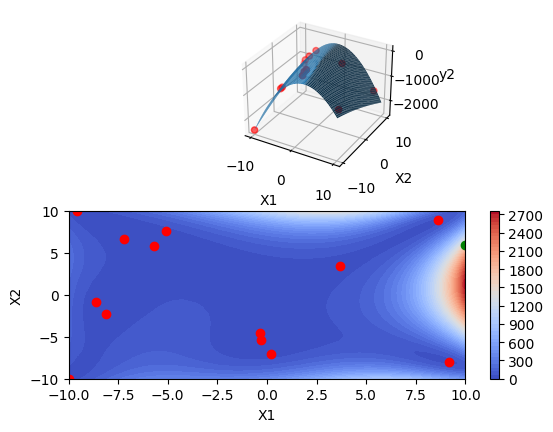

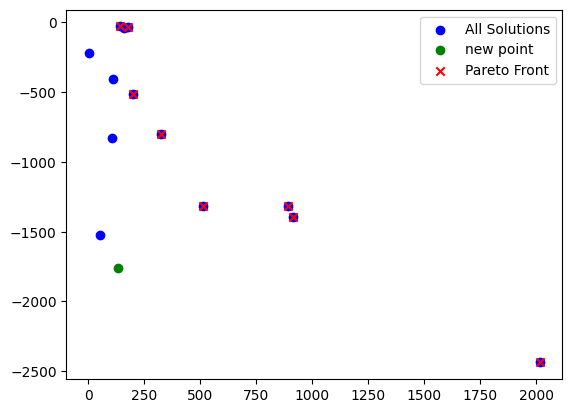

Branin function is [-2.77502443 -6.26160779]
Currin function is [-2.77502443 -6.26160779]
1.6983850900051718e-33
var is [[11321562.84838025]]
1.6983850900051718e-33
var is [[15119253.5127416]]


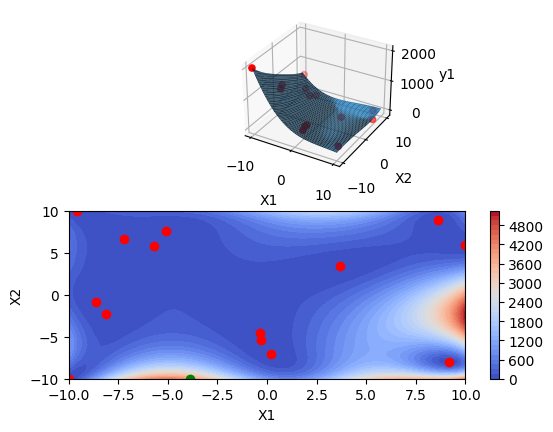

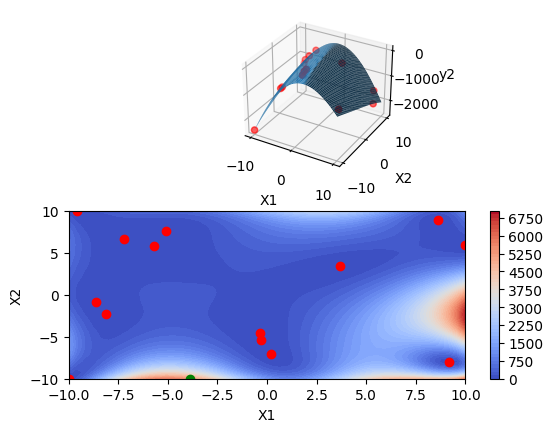

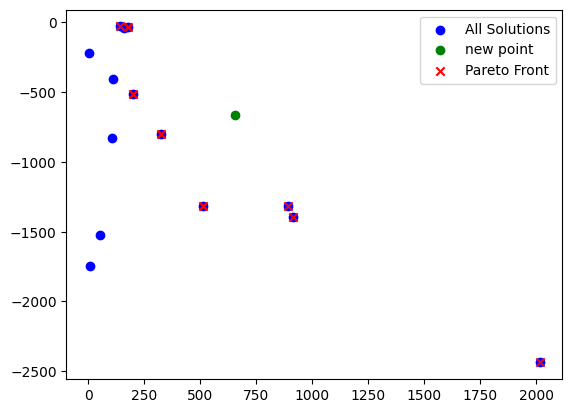

Branin function is [-2.54681306 -4.91271127]
Currin function is [-3.01730644 -7.0843699 ]
1.9569683284703768e-28
var is [[3363793.50328295]]
9.908080216959915e-46
var is [[37454412.09835152]]


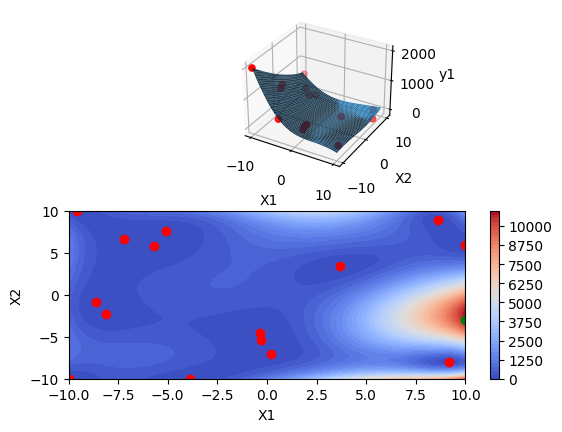

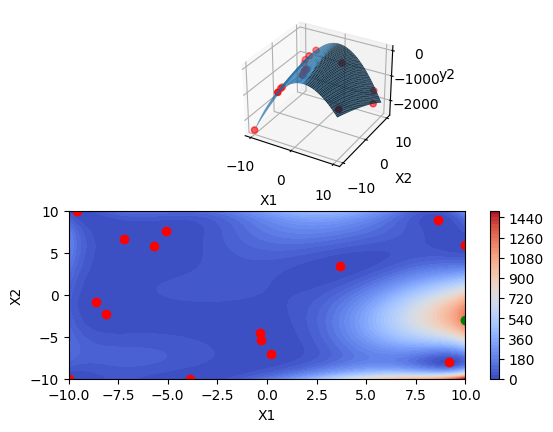

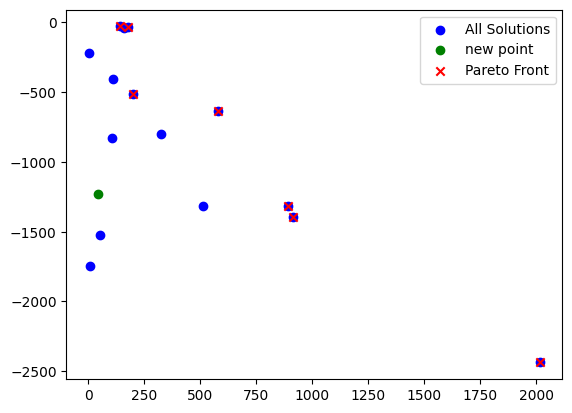

Branin function is [-2.75649914 -5.18643776]
Currin function is [-3.85445842 -5.78511527]
7.480407066539884e-38
var is [[7828813.00569943]]
1.6000222132242571e-65
var is [[4.51708194e+08]]


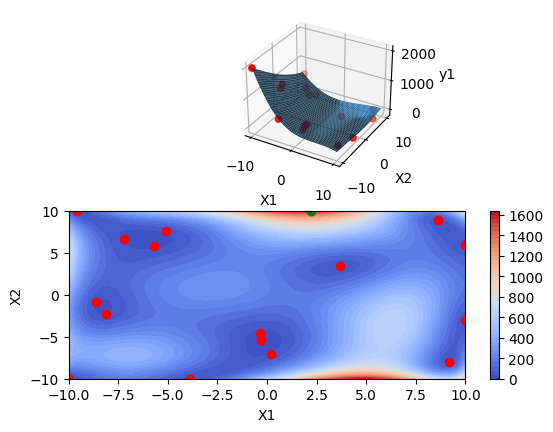

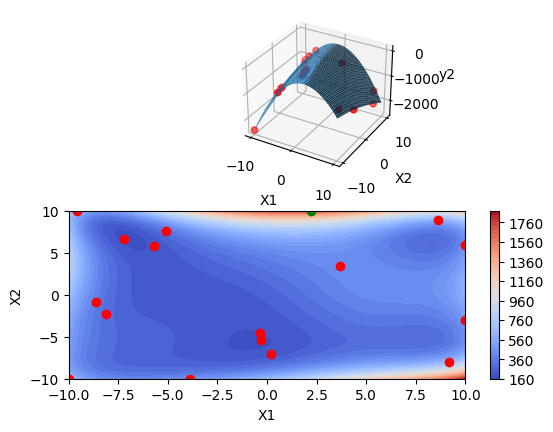

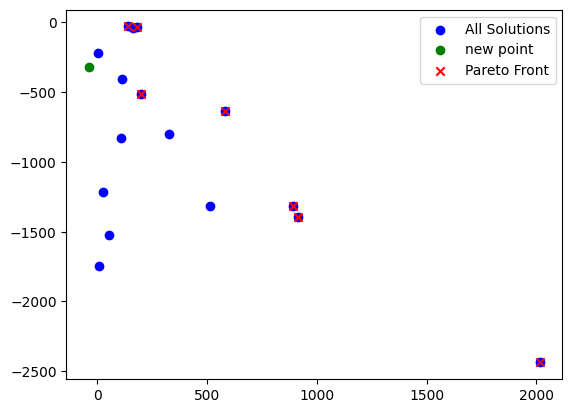

Branin function is [-2.65043257 -4.46958645]
Currin function is [-3.50246635 -6.52215005]
5.1358320283105837e-36
var is [[4446815.10367013]]
7.073017343206282e-69
var is [[1.31400741e+08]]


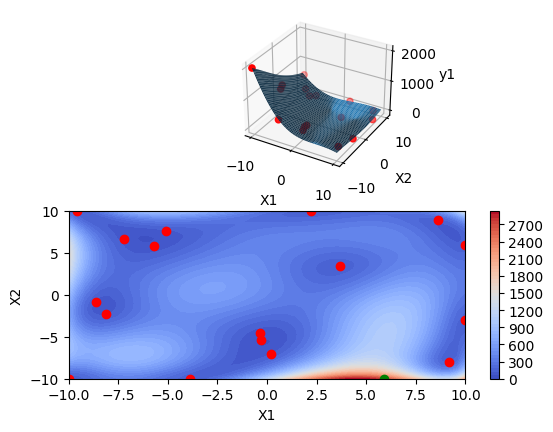

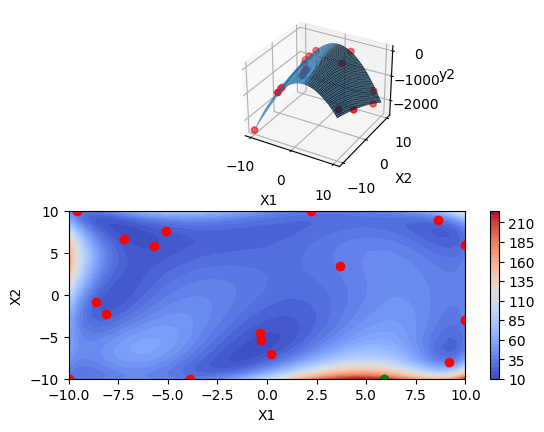

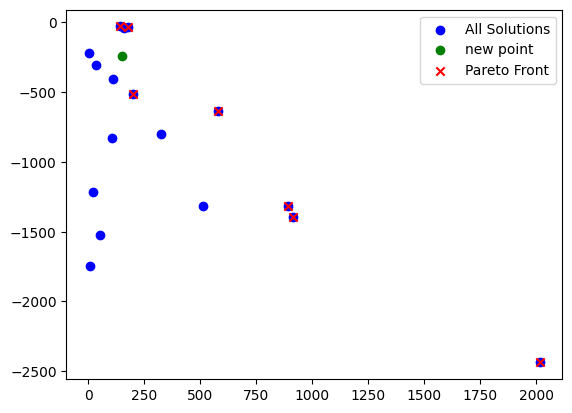

Branin function is [-2.86991565 -7.02672944]
Currin function is [-2.86991565 -7.02672944]
1.2190369346956147e-53
var is [[22450800.9603992]]
1.2190369346956147e-53
var is [[20643587.44277374]]


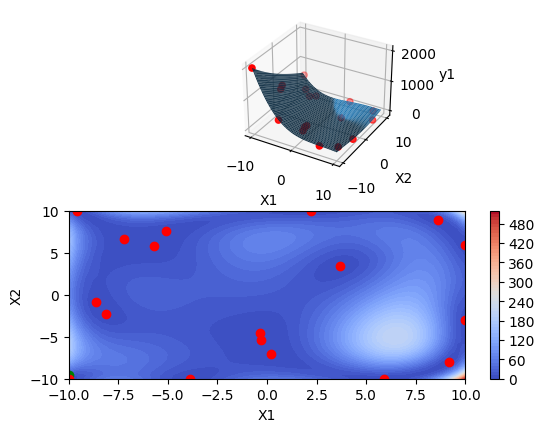

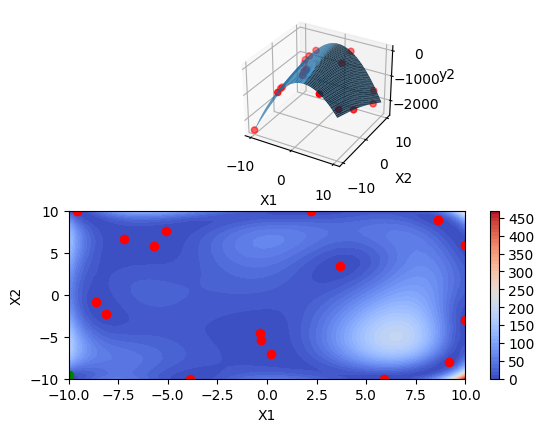

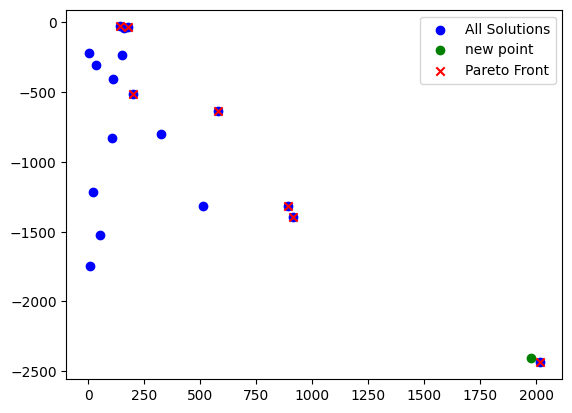

Branin function is [-2.69472664 -3.87220818]
Currin function is [-3.56454485 -5.58218058]
2.5182839711495414e-41
var is [[3831005.77560252]]
1.530116664395081e-74
var is [[1.15028703e+08]]


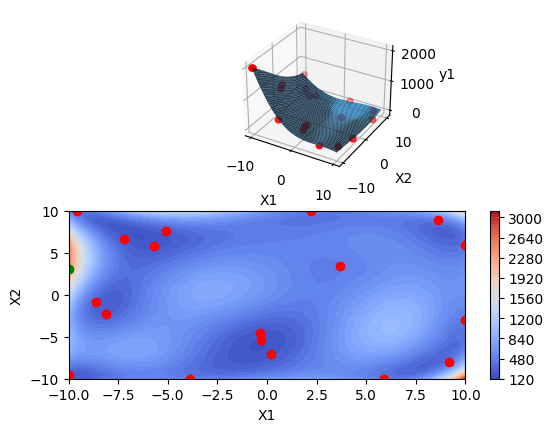

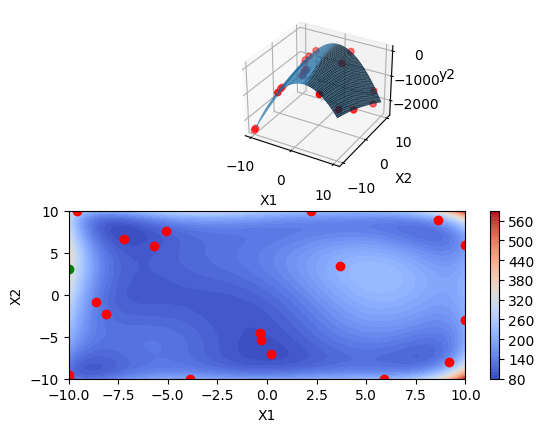

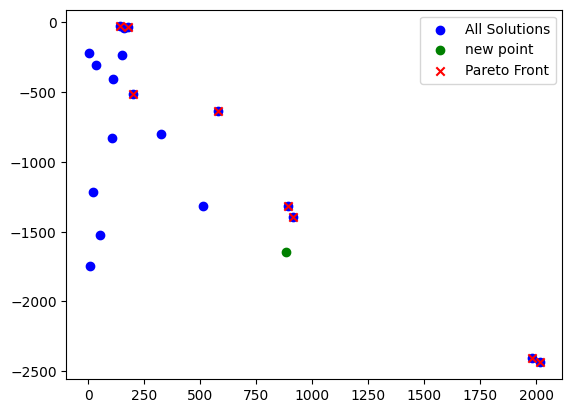

Branin function is [-2.05889035 -5.68014398]
Currin function is [-2.05889035 -5.68014398]
3.1367613483508117e-25
var is [[594078.56214672]]
3.1367613483508117e-25
var is [[1354754.66692262]]


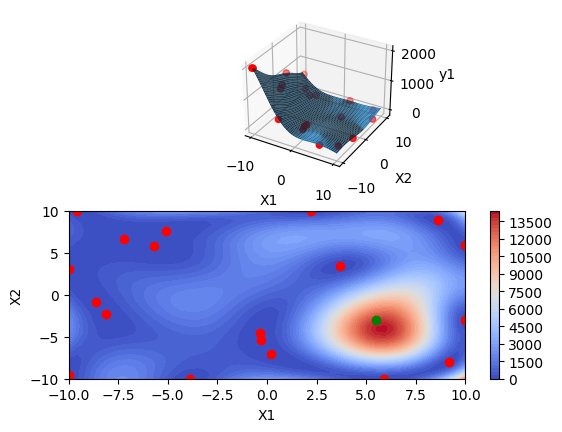

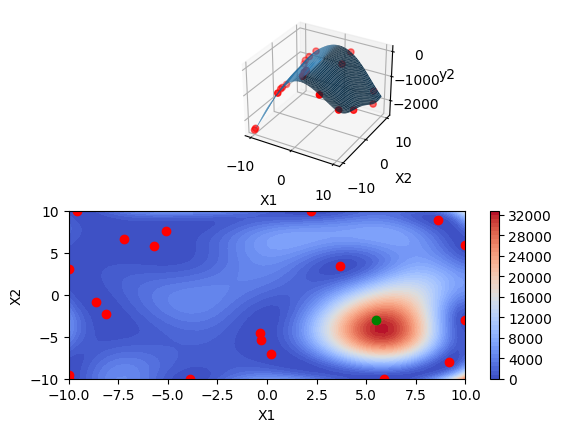

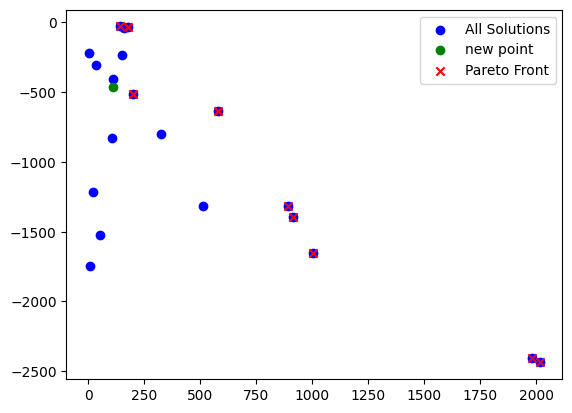

Branin function is [-2.52033198 -4.3468576 ]
Currin function is [-3.26418435 -6.47492197]
4.3749990008502654e-45
var is [[2875798.97867024]]
4.4252809703312594e-85
var is [[72768678.98154168]]


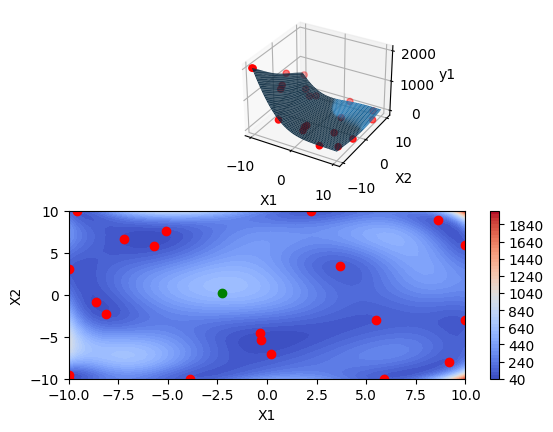

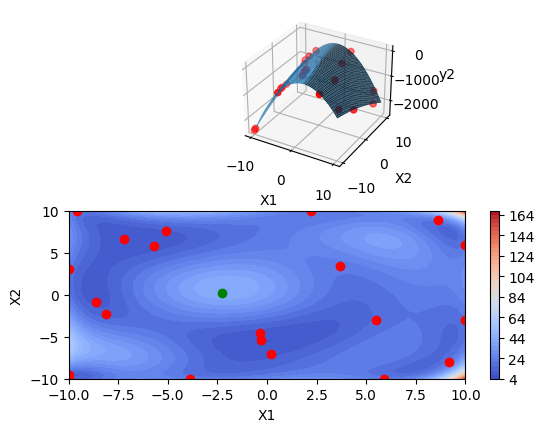

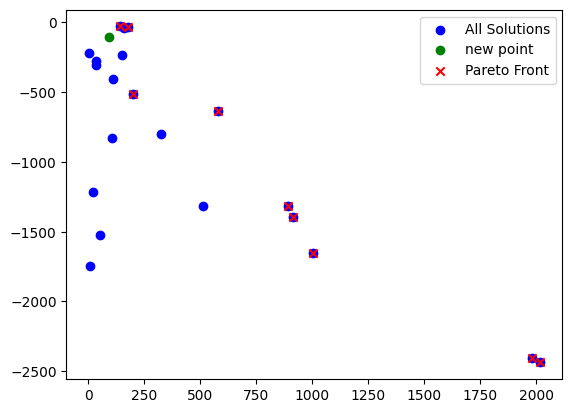

Branin function is [-2.37671115 -6.93545713]
Currin function is [-3.90949567 -7.50708402]
2.536711471216513e-47
var is [[1851300.67565325]]
3.699312237898168e-120
var is [[5.85935638e+08]]


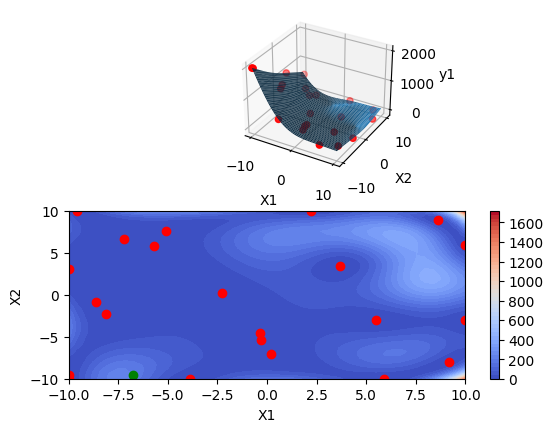

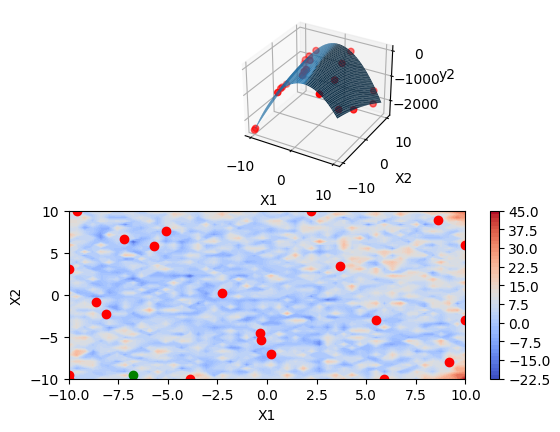

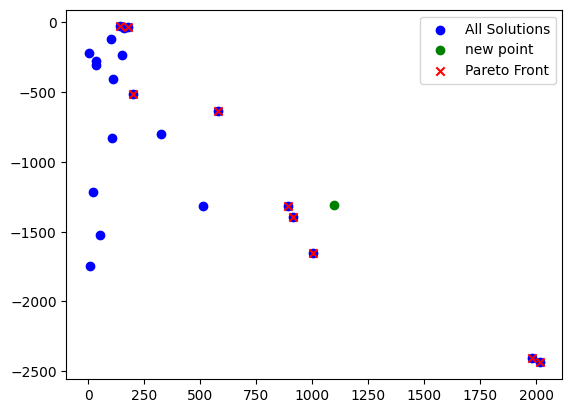

Branin function is [-2.76413906 -6.49369388]
Currin function is [-2.76413906 -6.49369388]
1.1965923613222539e-74
var is [[14359583.06010248]]
1.1965923613222539e-74
var is [[12368245.84405312]]


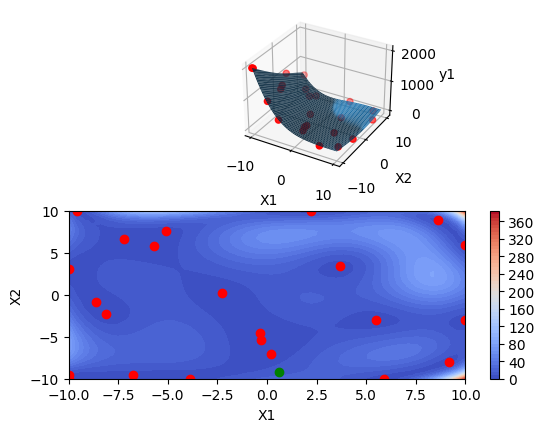

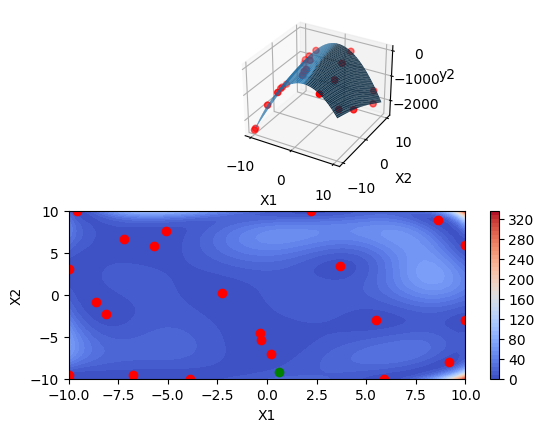

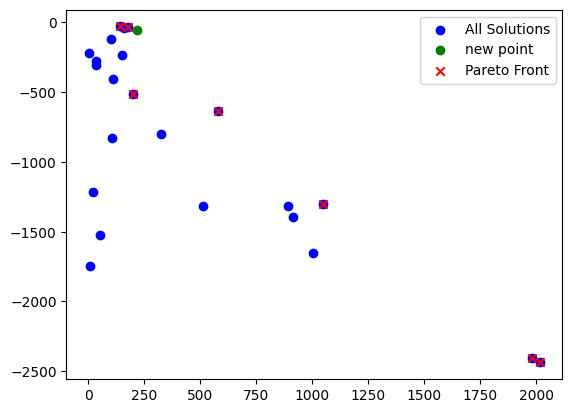

Branin function is [-3.02441503 -4.69046082]
Currin function is [-3.02441503 -4.69046082]
3.775357747370644e-77
var is [[25499228.21707318]]
3.775357747370644e-77
var is [[17103568.05767614]]


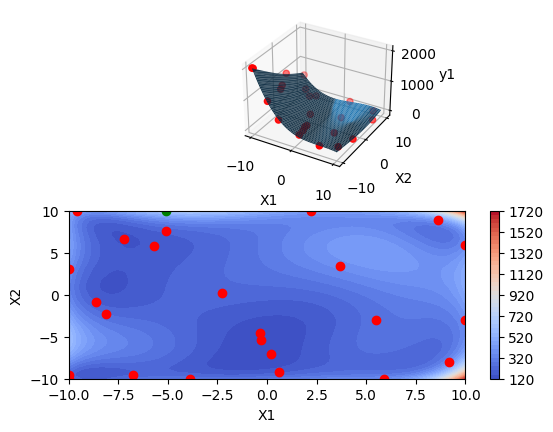

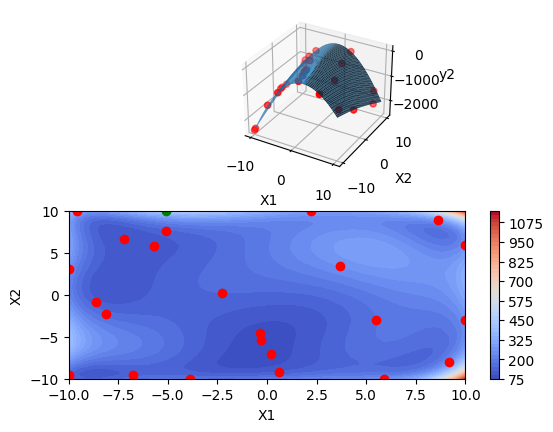

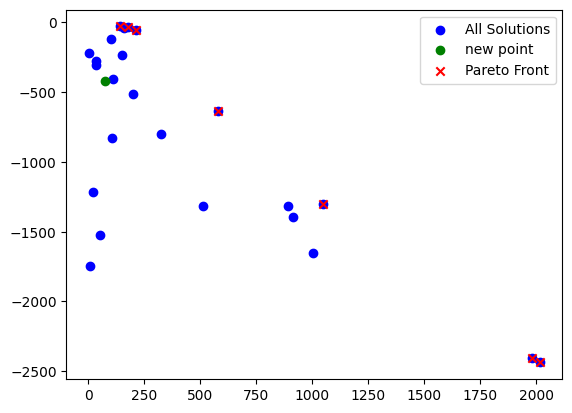

Branin function is [-2.88339095 -5.74861767]
Currin function is [-4.16864504 -7.60305653]
4.979215418475128e-87
var is [[20351843.23402473]]
3.1767342427131267e-149
var is [[1.29257071e+09]]


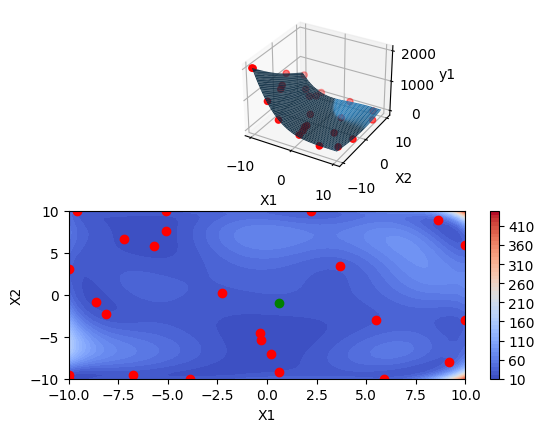

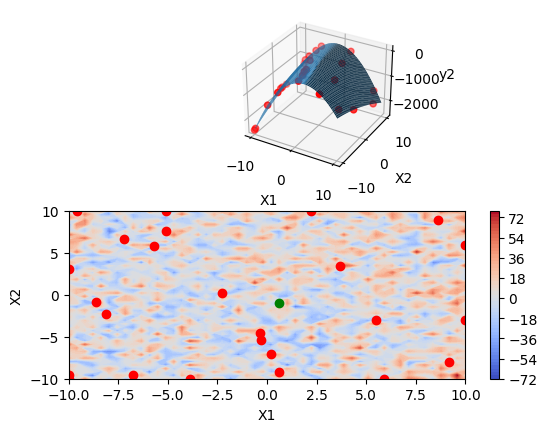

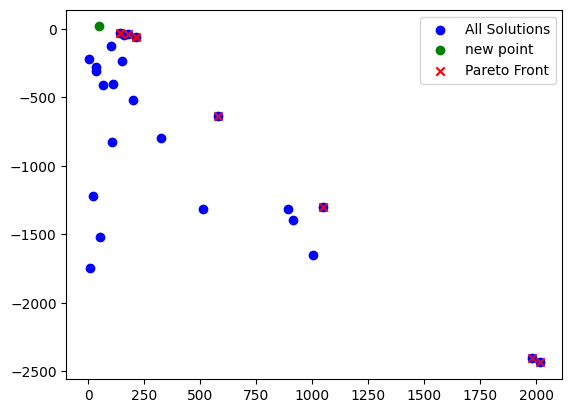

Branin function is [-2.34819489 -3.23463603]
Currin function is [-3.8289558 -5.9994831]
3.153530396669667e-47
var is [[1123624.59846718]]
3.2320161622495315e-124
var is [[2.59345407e+08]]


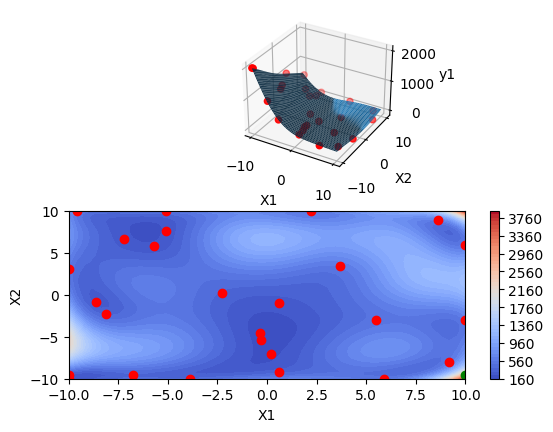

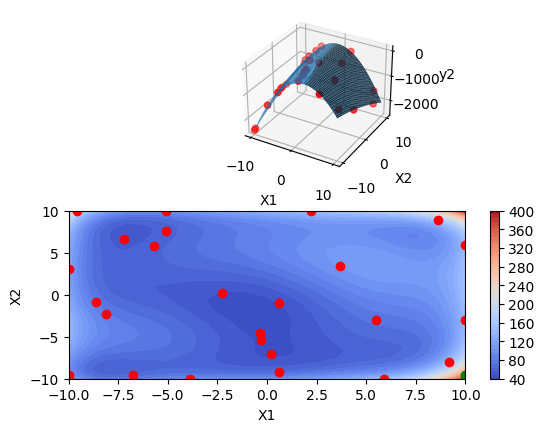

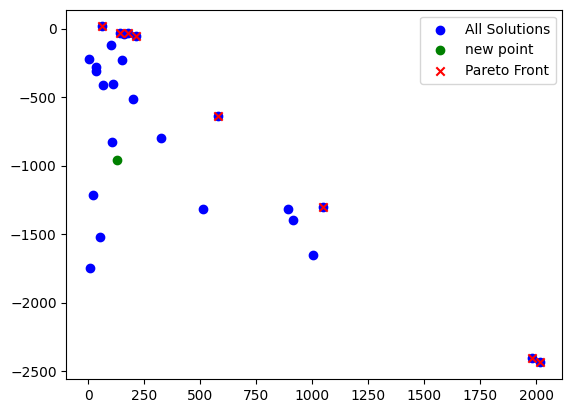

Branin function is [-2.5157924  -3.97442649]
Currin function is [-4.08541356 -7.4957845 ]
1.1981737449077802e-63
var is [[2309457.60840984]]
2.0633663386555456e-160
var is [[8.88043723e+08]]


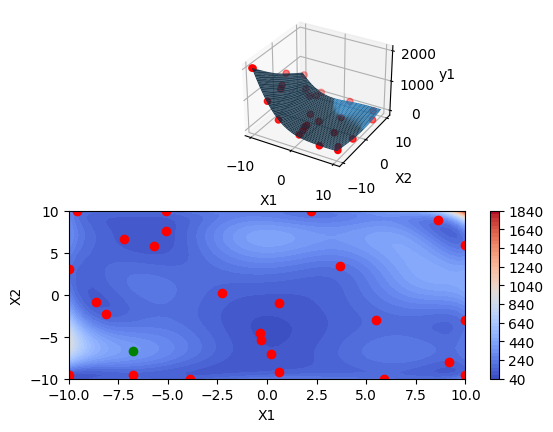

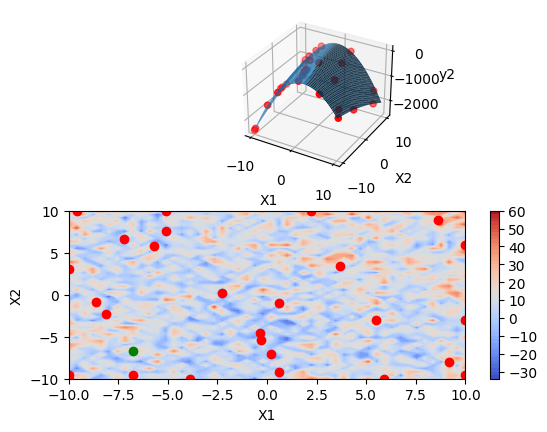

In [ ]:
###Normalizing section
##MOBO and Pareto front of these two functions
X_train = np.random.uniform(-10, 10, size=(10, 2))
  #F1 function values (Branin) #training value
y_train1=branin(X_train)
# y_train1=y_train1+np.random.normal(0,10,len(y_train1))
  #F2 function values (Currin) training vale
y_train2=currin(X_train)
# y_train2=y_train2+np.random.normal(0,5,len(y_train2))
##Test Values
X1, X2 =  np.meshgrid(np.linspace(-10,10, 50), np.linspace(-10, 10, 50))
X_test = np.c_[X1.ravel(), X2.ravel()]
for m in range(100):
    ##Process for MAP Optimization
    dimension = 2
    num_samples = 10
    lhs_samples = lhs(dimension, samples=num_samples)
    lowerbound1=-4.8
    upperbound1=-0.2
    lowerbound2=-7.8
    upperbound2=0.8
    lhs_samples1=np.zeros(lhs_samples.shape)
    lhs_samples1[:,0]=lowerbound1+lhs_samples[:,0]*(upperbound1-lowerbound1)
    lhs_samples1[:,1]=lowerbound2+lhs_samples[:,1]*(upperbound2-lowerbound2)
    bounds = [(-5, 0), (-8, 1)]
    opt_hyper1=[]
    opt_hyper2=[]
    optimum_hyperparameter_value1=[]
    optimum_hyperparameter_value2=[]
    rough_mean=-2.5
    nugget_mean=10**-3.5
#######Plot posterior first
    # ruf=np.arange(-5,0,0.1)
    # nug=np.arange(-19,1,0.4) ##It is in damn log space
    # rough_mean=-2.5
    # nugget_mean=10**-9
    # X,Y=np.meshgrid(ruf,nug)
    # z1=np.zeros((len(X[0]),len(Y[0])))
    # for i in range(len(X[0])):
    #     for j in range(len(Y[0])):
    #         omega=np.array([X[i][j],Y[i][j]])
    #         z1[i,j]=unnormalized_posterior(omega,rough_mean,nugget_mean,Log_Liklihood, prior,X_train,y_train2)

    # plt.figure(figsize=(8, 6))
    # levels = np.linspace(np.min(z1), np.max(z1), 10)
    # plt.contourf(X, Y, z1,levels=levels , cmap='viridis')  # or any other colormap
    # plt.scatter(lhs_samples1[:,0],lhs_samples1[:,1])
    # plt.show()
    for i in range(len(lhs_samples1)):
        initial_hyperparameters=lhs_samples1[i]
        Omega_optimal1 = minimize(unnormalized_posterior,initial_hyperparameters,args=(rough_mean,nugget_mean,Log_Liklihood,prior,X_train,y_train1),method='BFGS',bounds=bounds)
        Omega_optimal2 = minimize(unnormalized_posterior,initial_hyperparameters,args=(rough_mean,nugget_mean,Log_Liklihood,prior,X_train,y_train2),method='BFGS',bounds=bounds)
        opt_hyper1.append(Omega_optimal1.fun)
        opt_hyper2.append(Omega_optimal2.fun)
        optimum_hyperparameter_value1.append(Omega_optimal1.x)
        optimum_hyperparameter_value2.append(Omega_optimal2.x)
    opt_hyper1=np.array(opt_hyper1)
    index1=np.argmin(opt_hyper1)
    opt_hyper2=np.array(opt_hyper2)
    index2=np.argmin(opt_hyper2)
    hyperparameters1=optimum_hyperparameter_value1[index1]
    hyperparameters2=optimum_hyperparameter_value2[index2]
    print('Branin function is',hyperparameters1)
    print('Currin function is',hyperparameters2)
    ###Plot posterior with optimum hyperparameter
    # plt.figure(figsize=(8, 6))
    # levels = np.linspace(np.min(z1), np.max(z1), 10)
    # plt.contourf(X, Y, z1,levels=levels , cmap='viridis')  # or any other colormap
    # plt.scatter(lhs_samples1[:,0],lhs_samples1[:,1])
    ###Plot optimum point on posterior minimization plot
    # plt.scatter(hyperparameters2[0],hyperparameters2[1],color='red')
    # ##set C bar to real values
    # # min_val=np.min(z1)
    # # print(min_val)
    # # max_val=np.max(z1)
    # # print(max_val)
    # cbar = plt.colorbar(label='Value')
    # # cbar.set_ticks([min_val, (min_val + max_val)/ 2, max_val])
    # cbar=plt.colorbar(label='Z values')
    # plt.xlabel('Roughness',c='black')
    # plt.ylabel('nugget',c='black')
    # plt.title('Posterior distribution',c='w')
    # plt.grid(True)
    # plt.gca().tick_params(axis='x', colors='black')
    # plt.gca().tick_params(axis='y', colors='black')
    # plt.show()
    #########
    f_star1, var_f_star1 = gp_regression(X_train, y_train1, X_test, hyperparameters1)
    f_star2, var_f_star2 = gp_regression(X_train, y_train2, X_test, hyperparameters2)
    ###Reference point for the minimization
    Ref_point_1=min(min(y_train1),min(min(f_star1)+3*np.sqrt(max(np.diagonal(var_f_star1))),min(f_star1)-3*np.sqrt(max(np.diagonal(var_f_star1)))))
    Ref_point_2=max(min(y_train2),min(min(f_star2)+3*np.sqrt(max(np.diagonal(var_f_star2))),min(f_star1)-3*np.sqrt(max(np.diagonal(var_f_star2)))))
    Refs_point=np.column_stack((Ref_point_1,Ref_point_2))
    ###Initial Pareto front
    Initial_candidate=np.column_stack((y_train1, y_train2))
    is_pareto=identify_pareto_max(Initial_candidate)
    Initial_pareto=Initial_candidate[is_pareto]
    EHVI=np.zeros(len(X_test))
    for i in range(len(X_test)):
        y_test1=np.random.normal(f_star1[i], abs(var_f_star1[i][i]),10)
        y_test2=np.random.normal(f_star2[i], abs(var_f_star2[i][i]),10)
        HVI=np.zeros(len(y_test1))
        for j in range(len(y_test1)):
            Secondary_candidates=np.append(Initial_candidate,np.array([y_test1[j],y_test2[j]])).reshape(-1,2)
            # ##Secondary pareto front
            is_pareto2=identify_pareto_max(Secondary_candidates)
            Secondary_pareto=Secondary_candidates[is_pareto2]
            Secondary_sorted_pareto=sorted(Secondary_pareto,key=lambda x: x[0],reverse=False)
            a=HyperVolume_maximization(Secondary_sorted_pareto,Refs_point[0])
            Initial_Sorted_pareto=sorted(Initial_pareto,key=lambda x: x[0],reverse=False)
            b=HyperVolume_maximization(Initial_Sorted_pareto,Refs_point[0])
            HVI[j]=a-b
            # plot_area(Initial_Sorted_pareto,Secondary_sorted_pareto,Refs_point[0])
        EHVI[i]=np.array(HVI).mean()
    c1=np.where(EHVI==max(EHVI))
    if np.array(X_test[c1[0]] in X_train==True).any():
        print('exists')
        continue
    y_1=branin(X_test[c1[0]]) ##True value
    y_1=y_1+np.random.normal(0,10,1)
    y_2=currin(X_test[c1[0]])###True value
    # y_2=y_2+np.random.normal(0,5,1)
    y_11=f_star1[c1[0]]
    y_22=f_star2[c1[0]]
    ##Plot 2D GP
    fig = plt.figure()
    ax = fig.add_subplot(211, projection='3d')

    ax.scatter(X_train[:, 0],X_train[:, 1], y_train1, c='r', marker='o')
    ax.plot_surface(X1, X2, f_star1.reshape(X1.shape), alpha=1)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('y1')
    ax = fig.add_subplot(212)
    c = ax.contourf(X1,X2 , var_f_star1.diagonal().reshape(X1.shape), levels=50, cmap='coolwarm')
    ax.scatter(X_test[c1[0]][0][0],X_test[c1[0]][0][1], c='g', marker='o')
    plt.colorbar(c)
    ax.scatter(X_train[:, 0],X_train[:, 1], c='r', marker='o')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(211, projection='3d')

    ax.scatter(X_train[:, 0],X_train[:, 1], y_train2, c='r', marker='o')
    ax.plot_surface(X1, X2, f_star2.reshape(X1.shape), alpha=1)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('y2')
    ax = fig.add_subplot(212)
    c = ax.contourf(X1,X2 , var_f_star2.diagonal().reshape(X1.shape), levels=50, cmap='coolwarm')
    plt.colorbar(c)
    ax.scatter(X_train[:, 0],X_train[:, 1], c='r', marker='o')
    X_test[c1[0]][0][0]
    ax.scatter(X_test[c1[0]][0][0],X_test[c1[0]][0][1], c='g', marker='o')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    plt.show()

    ##Plot Gp Prediction
    ax = fig.add_subplot()
    y_train1=y_train1.reshape(-1,1)
    y_train2=y_train2.reshape(-1,1)
    plt.scatter(y_train1[:, 0], y_train2[:, 0], label='All Solutions', c='b', marker='o')
    plt.scatter(y_11, y_22, label='new point', c='g', marker='o')
    plt.scatter(Initial_pareto[:, 0], Initial_pareto[:, 1], label='Pareto Front', c='r', marker='x')
    plt.legend()
    ##Plot Y space
    X_train=np.append(X_train, X_test[c1[0]]).reshape(-1,2)
    y_train1=np.append(y_train1,y_1).reshape(-1,1)
    y_train2=np.append(y_train2,y_2).reshape(-1,1)
    Initial_candidate=np.append(Initial_candidate,np.array([y_1, y_2])).reshape(-1,2)
    is_pareto2=identify_pareto_max(Initial_candidate)
    Initial_pareto=Initial_candidate[is_pareto2]
    # plt.scatter(Refs_point[0][0], Refs_point[0][1], label='Ref_point', c='k', marker='x')

    plt.gca().tick_params(axis='x', colors='black')
    plt.gca().tick_params(axis='y', colors='black')
    if i==0:
      plt.savefig('start')
    elif i==99:
      plt.savefig('end')
    plt.show()